# BIAFlows

## Nuclei Tracking 2D+t

### Fiji-workflow

The workflow treats the time-dimension as z-dimension and does a 3D-segmentation of the objects. The resulting object slices are then reduced to a center point.

In [2]:
from getpass import getpass 

publicKey = getpass("Please enter the public key: ")
privateKey = getpass("Please enter the private key: ")

argv = ['--cytomine_public_key', publicKey, 
 '--cytomine_host',  'biaflows.neubias.org',
 '--cytomine_private_key',  privateKey,
 '--cytomine_id_project',  '1695226', 
 '--cytomine_id_software', '11244427',
 '--ij_gauss_radius',  '3',
 '--ij_threshold',  '60',
 '--ij_open_radius', '7']

Please enter the public key: ········
Please enter the private key: ········


Import CytomineJob and Job and update the status information. Set the problem class to particle-tracking (PrtTrk).

In [3]:
import sys
from subprocess import call

from cytomine.models import Job
from neubiaswg5.helpers import NeubiasJob, prepare_data, upload_data, upload_metrics
from neubiaswg5 import CLASS_PRTTRK

jobID=-666
with NeubiasJob.from_cli(argv) as nj:
    nj.job.update(status=Job.RUNNING, progress=0, statusComment="Initialisation...")
    jobID = nj.job.id
    
problem_cls = CLASS_PRTTRK

[2019-10-11 13:49:38,612][INFO] [GET] [currentuser] CURRENT USER - 3002336 : guest | 200 OK
[2019-10-11 13:49:38,878][INFO] [GET] [project] 1695226 : NUCLEI-TRACKING-NODIVISION | 200 OK
[2019-10-11 13:49:39,142][INFO] [GET] [software] 11244427 : NucleiTracking-ImageJ | 200 OK
[2019-10-11 13:49:39,393][INFO] [GET] [softwareparameter collection] 8 objects | 200 OK
[2019-10-11 13:49:39,755][INFO] [POST] [job] 21022225 : None | 200 OK
[2019-10-11 13:49:40,015][INFO] [GET] [user] 21022231 : JOB[guest ], 2019-10-11 13:49:39:663 | 200 OK
[2019-10-11 13:49:40,270][INFO] [GET] [currentuser] CURRENT USER - 21022231 : JOB[guest ], 2019-10-11 13:49:39:663 | 200 OK
[2019-10-11 13:49:40,272][INFO] Job (id:21022225) status update: "None" (status: RUNNING, progress: 0%)
[2019-10-11 13:49:40,614][INFO] [PUT] [job] 21022225 : None | 200 OK
[2019-10-11 13:49:40,939][INFO] [POST] [jobparameter] 21022238 : ij_gauss_radius | 200 OK
[2019-10-11 13:49:41,259][INFO] [POST] [jobparameter] 21022244 : ij_threshol

#### Create local directories and download images

Create the local working directories in a subfolder jobID of the user's home folder.

- in: input images
- out: output images
- ground_truth: ground truth images
- tmp: temporary path

In [4]:
in_images, gt_images, in_path, gt_path, out_path, tmp_path = prepare_data(problem_cls, nj, is_2d=False, **nj.flags)

[2019-10-11 13:49:47,494][INFO] Job (id:21022225) status update: "Downloading images (to /home/jovyan/21022225/in)..." (status: SUCCESS/TERMINATED, progress: 0%)
[2019-10-11 13:49:47,796][INFO] [PUT] [job] 21022225 : None | 200 OK
[2019-10-11 13:49:48,053][INFO] [GET] [imagegroup collection] 2 objects | 200 OK
[2019-10-11 13:49:50,179][INFO] File downloaded successfully from http://biaflows.neubias.org/api/imagegroup/4042304/download
[2019-10-11 13:49:51,849][INFO] File downloaded successfully from http://biaflows.neubias.org/api/imagegroup/4042708/download


Check the downloaded input and ground-truth images. In this case there is only one time-series as input image and one time-series as ground-truth image.

In [5]:
print(in_path)
!ls -alh $in_path
print(gt_path)
!ls -alh $gt_path

/home/jovyan/21022225/in
total 13M
drwxr-xr-x 2 jovyan jovyan 4.0K Oct 11 13:49 .
drwxr-xr-x 6 jovyan jovyan 4.0K Oct 11 13:49 ..
-rw-r--r-- 1 jovyan jovyan  13M Oct 11 13:49 4042304.tif
/home/jovyan/21022225/ground_truth
total 25M
drwxr-xr-x 2 jovyan jovyan 4.0K Oct 11 13:49 .
drwxr-xr-x 6 jovyan jovyan 4.0K Oct 11 13:49 ..
-rw-r--r-- 1 jovyan jovyan  25M Oct 11 13:49 4042304.tif


#### Call the image analysis workflow 

In [6]:
nj.job.update(progress=25, statusComment="Launching workflow...")
command = "/usr/bin/xvfb-run ./ImageJ-linux64 -macro macro.ijm \"input={}, output={}, gauss_rad={}, threshold={}, open_rad={}\" -batch".format(in_path, out_path, nj.parameters.ij_gauss_radius, nj.parameters.ij_threshold, nj.parameters.ij_open_radius)

return_code = call(command, shell=True, cwd="./fiji")  # waits for the subprocess to return

if return_code != 0:
    err_desc = "Failed to execute the ImageJ macro (return code: {})".format(return_code)
    nj.job.update(progress=50, statusComment=err_desc)
    raise ValueError(err_desc)
nj.job.update(progress=30, statusComment="Workflow finished...")

[2019-10-11 13:49:54,736][INFO] Job (id:21022225) status update: "Launching workflow..." (status: SUCCESS/TERMINATED, progress: 1%)
[2019-10-11 13:49:55,119][INFO] [PUT] [job] 21022225 : None | 200 OK
[2019-10-11 13:50:38,556][INFO] Job (id:21022225) status update: "Workflow finished..." (status: SUCCESS/TERMINATED, progress: 25%)
[2019-10-11 13:50:38,908][INFO] [PUT] [job] 21022225 : None | 200 OK


#### Visualize the result of the workflow

In [7]:
macro = '\
open("'+in_path + '/' + str(in_images[0].object.id)+'.tif"); \n\
cellsStackID = getImageID(); \n\
run("Duplicate...", " "); \n\
cellsTitle = getTitle(); \n\
selectImage(cellsStackID); \n\
close(); \n\
open("'+out_path + '/' + str(in_images[0].object.id)+'.tif"); \n\
tracesStackID = getImageID(); \n\
run("Z Project...", "projection=[Max Intensity]"); \n\
run("3-3-2 RGB"); \n\
run("Maximum...", "radius=4"); \n\
run("8-bit"); \n\
tracesTitle = getTitle(); \n\
run("Merge Channels...", "c2="+tracesTitle+" c4="+cellsTitle+" create"); \n\
selectImage(tracesStackID); \n\
close(); \n\
overlayID = getImageID(); \n\
run("Capture Image"); \n\
selectImage(overlayID); \n\
close(); \n\
resultTitle=getTitle(); \n\
saveAs("jpeg", "'+tmp_path+'/'+str(in_images[0].object.id)+'"); \n\
close(); \n\
run("Quit"); \n\
'

file = open(tmp_path + "/visualize_tracks.ijm", "w") 
 
file.write(macro) 
file.close() 

print(macro)

open("/home/jovyan/21022225/in/4042304.tif"); 
cellsStackID = getImageID(); 
run("Duplicate...", " "); 
cellsTitle = getTitle(); 
selectImage(cellsStackID); 
close(); 
open("/home/jovyan/21022225/out/4042304.tif"); 
tracesStackID = getImageID(); 
run("Z Project...", "projection=[Max Intensity]"); 
run("3-3-2 RGB"); 
run("Maximum...", "radius=4"); 
run("8-bit"); 
tracesTitle = getTitle(); 
run("Merge Channels...", "c2="+tracesTitle+" c4="+cellsTitle+" create"); 
selectImage(tracesStackID); 
close(); 
overlayID = getImageID(); 
run("Capture Image"); 
selectImage(overlayID); 
close(); 
resultTitle=getTitle(); 
saveAs("jpeg", "/home/jovyan/21022225/tmp/4042304"); 
close(); 
run("Quit"); 



In [8]:
command = "/usr/bin/xvfb-run ./ImageJ-linux64 -macro "+tmp_path + "/visualize_tracks.ijm -batch"

return_code = call(command, shell=True, cwd="./fiji")  # waits for the subprocess to return

if return_code > 1:
    err_desc = "Failed to execute the ImageJ macro (return code: {})".format(return_code)
    nj.job.update(progress=50, statusComment=err_desc)
    raise ValueError(err_desc)

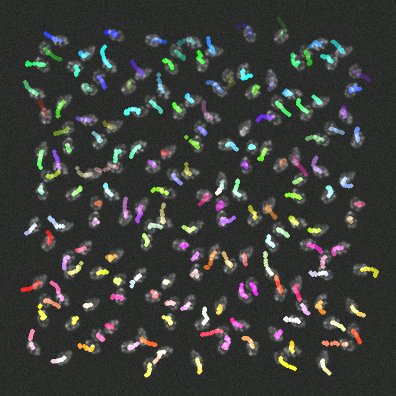

In [9]:
from IPython.display import Image
Image(filename = tmp_path+'/'+str(in_images[0].object.id)+'.jpg')

#### Calculate metrics

In [12]:
from neubiaswg5.metrics import computemetrics_batch
from cytomine.models import Property
import os
os.chdir("/home/jovyan/neubiaswg5-utilities/neubiaswg5/metrics")
import re
import shutil
import sys
import subprocess 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy import ndimage
import tifffile as tiff
from scipy.spatial import cKDTree
from neubiaswg5 import *
from neubiaswg5 import CLASS_LNDDET
from img_to_xml import *
from img_to_seq import *
from skl2obj import *
from netmets_obj import netmets_obj
from node_sorter import swc_node_sorter
from node_sorter import findchildren

os.chdir("/home/jovyan/")

def computemetrics(infile, reffile, problemclass, tmpfolder, verbose=True, **extra_params):
    outputs = _computemetrics(infile, reffile, problemclass, tmpfolder, **extra_params)
    return outputs


def get_image_metadata(tiff):
    import xml.etree.ElementTree as ET
    return list(list(ET.fromstring(tiff.ome_metadata))[0])[0].attrib


def get_dimensions(tiff, time=False):
    array = tiff.asarray()
    T, Z = 1, 1
    if array.ndim > 2:
        metadata = get_image_metadata(tiff)
        Y, X = int(metadata['SizeY']), int(metadata['SizeX'])
        if array.ndim > 3 or time:
            T = int(metadata['SizeT'])
        if array.ndim > 3 or not time:
            Z = int(metadata['SizeZ'])
    else:
        Y, X = array.shape
    return T, Z, Y, X


def _computemetrics(infile, reffile, problemclass, tmpfolder, **extra_params):
    # Remove all xml and txt (temporary) files in tmpfolder
    filelist = [ f for f in os.listdir(tmpfolder) if (f.endswith(".xml") or f.endswith(".txt")) ]
    for f in filelist:
        os.remove(os.path.join(tmpfolder, f))

    # Remove all (temporary) subdirectories in tmpfolder
    for subdir in next(os.walk(tmpfolder))[1]:
        shutil.rmtree(os.path.join(tmpfolder, subdir), ignore_errors=True)

    metrics_dict = {}
    params_dict = {}
    

    # Read metadata from reference image (OME-TIFF)
    img = tiff.TiffFile(reffile)
    T, Z, Y, X = get_dimensions(img, time=False)

    # Convert non null pixels coordinates to track files
    ref_xml_fname = os.path.join(tmpfolder, "reftracks.xml")
    tracks_to_xml(ref_xml_fname, img_to_tracks(reffile,X,Y,Z,T), True)
    in_xml_fname = os.path.join(tmpfolder, "intracks.xml")
    tracks_to_xml(in_xml_fname, img_to_tracks(infile,X,Y,Z,T), True)
    res_fname = in_xml_fname + ".score.txt"

    # Call tracking metric code
    gating_dist = extra_params.get("gating_dist", 5)
    # the fourth parameter represents the gating distance
    os.system('java -jar /home/jovyan/neubiaswg5-utilities/bin/TrackingPerformance.jar -r ' + ref_xml_fname + ' -c ' + in_xml_fname + ' -o ' + res_fname + ' ' + str(gating_dist))

    # Parse the output file created automatically in tmpfolder
    with open(res_fname, "r") as f:
        bchmetrics = [line.split(':')[0].strip() for line in f.readlines()]

    metric_names = [
        "PD", "NPSA", "FNPSB", "NRT", "NCT",
        "JST", "NPT", "NMT", "NST", "NRD",
        "NCD", "JSD", "NPD", "NMD", "NSD"
    ]
    metrics_dict.update({name: value for name, value in zip(metric_names, bchmetrics)})
    params_dict["GATING_DIST"] = gating_dist

    return metrics_dict, params_dict

nj.job.update(progress=80, statusComment="Computing and uploading metrics...")
outfiles, reffiles = zip(*[
    (os.path.join(out_path, "{}.tif".format(image.object.id)),
     os.path.join(gt_path, "{}.tif".format(image.object.id)))
    for image in in_images
])

for infile, reffile in zip(outfiles, reffiles):
    metrics = computemetrics(infile, reffile, problem_cls, tmp_path, {})

[2019-10-11 13:53:38,435][INFO] Job (id:21022225) status update: "Computing and uploading metrics..." (status: SUCCESS/TERMINATED, progress: 80%)
[2019-10-11 13:53:38,762][INFO] [PUT] [job] 21022225 : None | 200 OK


In [14]:
path = tmp_path+'/'+"intracks.xml.score.txt"
print(path)
with open(path) as file:
    for line in file:
        print(line)

/home/jovyan/21022225/tmp/intracks.xml.score.txt
354.38499817254285	 : pairing distance

0.5806094696182924	 : normalized pairing score (alpha)

0.5084093283186084	 : full normalized score (beta)

169	 : number of reference tracks

169	 : number of candidate tracks

0.7512953367875648	 : Similarity between tracks (Jaccard)

145	 : number of paired tracks

24	 : number of missed tracks (out of 169)

24	 : number of spurious tracks)

169	 : number of reference detections

169	 : number of candidate detections

0.7512953367875648	 : Similarity between detections (Jaccard)

145	 : number of paired detections

24	 : number of missed detections (out of 169)

24	 : number of spurious detections



In [13]:
print("test")

test
